# Spleen CODEX + RNA-seq Integration with MaxFuse

This notebook integrates spleen CODEX protein data with scRNA-seq data using MaxFuse.

**Using RAW unfiltered RNA data** to ensure proper cell calling and filtering:
- Raw data: 6.8M barcodes (includes empty droplets)
- Will apply proper QC filtering to identify real cells
- This avoids issues from pre-filtered data that may have been processed differently

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import sparse

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

import anndata as ad
import scanpy as sc
import maxfuse as mf

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

## Step 1: Load and Preprocess Data

**CRITICAL**: We must filter both datasets FIRST, then extract shared features.
This ensures `shared_arr` and `active_arr` have the same number of cells.

In [2]:
# Load protein (CODEX) data
protein_adata = ad.read_h5ad("1904_CC2B_set1_analysis.h5ad")
print(f"Protein raw: {protein_adata.shape}")
print(f"Protein markers: {list(protein_adata.var_names)}")

Protein raw: (189470, 24)
Protein markers: ['CD1c', 'CD3e', 'CD4', 'CD8', 'CD11c', 'CD15', 'CD20', 'CD21', 'CD31', 'CD34', 'CD35', 'CD44', 'CD45', 'CD45RO', 'CD68', 'CD107a', 'CD163', 'HLADR', 'Lyve1', 'SMActin', 'Vimentin', 'CollagenIV', 'Ki67', 'FoxP3']


In [3]:
# Load RAW RNA data (unfiltered - includes empty droplets)
print("Loading RAW RNA matrix (this may take a moment)...")
rna_mtx = mmread("raw_feature_bc_matrix/matrix.mtx.gz")
rna_names = pd.read_csv('raw_feature_bc_matrix/features.tsv.gz', sep='\t', header=None)[1].to_numpy()
rna_barcodes = pd.read_csv('raw_feature_bc_matrix/barcodes.tsv.gz', header=None)[0].values

rna_adata = ad.AnnData(rna_mtx.T.tocsr(), dtype=np.float32)
rna_adata.var_names = rna_names
rna_adata.var_names_make_unique()
rna_adata.obs_names = rna_barcodes

print(f"RNA raw (unfiltered): {rna_adata.shape}")
print(f"  This includes empty droplets - will filter next")

Loading RAW RNA matrix (this may take a moment)...
RNA raw (unfiltered): (6794880, 33538)
  This includes empty droplets - will filter next


### Filter RNA data - Identify real cells from empty droplets

We need to properly filter the raw data to identify real cells. This is critical for good integration.

In [4]:
# Calculate QC metrics for cell filtering
print("Calculating QC metrics...")

# Basic QC metrics
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(f"\nQC metric ranges (before filtering):")
print(f"  Total counts: {rna_adata.obs['total_counts'].min():.0f} - {rna_adata.obs['total_counts'].max():.0f}")
print(f"  Genes detected: {rna_adata.obs['n_genes_by_counts'].min():.0f} - {rna_adata.obs['n_genes_by_counts'].max():.0f}")
print(f"  MT %: {rna_adata.obs['pct_counts_mt'].min():.1f} - {rna_adata.obs['pct_counts_mt'].max():.1f}")

Calculating QC metrics...

QC metric ranges (before filtering):
  Total counts: 0 - 93646
  Genes detected: 0 - 7090
  MT %: 0.0 - 100.0


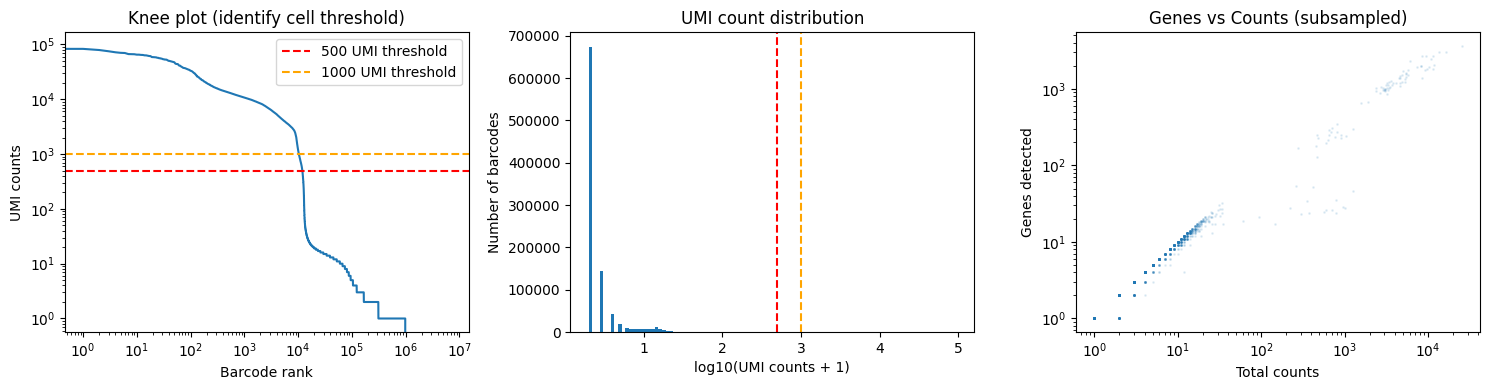

Cells with >= 100 UMI: 13,022
Cells with >= 200 UMI: 12,795
Cells with >= 500 UMI: 11,999
Cells with >= 1000 UMI: 10,335
Cells with >= 2000 UMI: 9,269


In [5]:
# Visualize count distribution to identify cell calling threshold
# Plot UMI counts per barcode (knee plot)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Knee plot - sorted UMI counts
counts_sorted = np.sort(rna_adata.obs['total_counts'].values)[::-1]
axes[0].plot(np.arange(len(counts_sorted)), counts_sorted)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel('Barcode rank')
axes[0].set_ylabel('UMI counts')
axes[0].set_title('Knee plot (identify cell threshold)')
axes[0].axhline(y=500, color='r', linestyle='--', label='500 UMI threshold')
axes[0].axhline(y=1000, color='orange', linestyle='--', label='1000 UMI threshold')
axes[0].legend()

# Histogram of counts (log scale, filtered to show distribution)
counts_nonzero = rna_adata.obs['total_counts'][rna_adata.obs['total_counts'] > 0]
axes[1].hist(np.log10(counts_nonzero + 1), bins=100)
axes[1].set_xlabel('log10(UMI counts + 1)')
axes[1].set_ylabel('Number of barcodes')
axes[1].set_title('UMI count distribution')
axes[1].axvline(x=np.log10(500), color='r', linestyle='--')
axes[1].axvline(x=np.log10(1000), color='orange', linestyle='--')

# Genes vs counts
sample_idx = np.random.choice(len(rna_adata), min(50000, len(rna_adata)), replace=False)
axes[2].scatter(rna_adata.obs['total_counts'].values[sample_idx], 
                rna_adata.obs['n_genes_by_counts'].values[sample_idx], 
                alpha=0.1, s=1)
axes[2].set_xlabel('Total counts')
axes[2].set_ylabel('Genes detected')
axes[2].set_title('Genes vs Counts (subsampled)')
axes[2].set_xscale('log')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

# Count cells at different thresholds
for thresh in [100, 200, 500, 1000, 2000]:
    n_cells = (rna_adata.obs['total_counts'] >= thresh).sum()
    print(f"Cells with >= {thresh} UMI: {n_cells:,}")

In [ ]:
# Apply cell filtering
# Based on knee plot analysis - using both min and max filters to remove:
# - Empty droplets / low-quality cells (min filters)
# - Doublets / multiplets (max filters)

MIN_COUNTS = 200      # Minimum UMI counts per cell
MAX_COUNTS = 40000    # Maximum UMI counts (remove doublets)
MIN_GENES = 200       # Minimum genes detected per cell  
MAX_GENES = 6000      # Maximum genes detected (remove doublets)
MAX_MT_PCT = 15       # Maximum mitochondrial percentage

print(f"Filtering criteria:")
print(f"  Min UMI counts: {MIN_COUNTS}")
print(f"  Max UMI counts: {MAX_COUNTS}")
print(f"  Min genes: {MIN_GENES}")
print(f"  Max genes: {MAX_GENES}")
print(f"  Max MT%: {MAX_MT_PCT}")

# Apply filters
print(f"\nBefore filtering: {rna_adata.n_obs:,} barcodes")

# Min filters
sc.pp.filter_cells(rna_adata, min_counts=MIN_COUNTS)
print(f"After min_counts filter: {rna_adata.n_obs:,} cells")

sc.pp.filter_cells(rna_adata, min_genes=MIN_GENES)
print(f"After min_genes filter: {rna_adata.n_obs:,} cells")

# Max filters (remove doublets)
rna_adata = rna_adata[rna_adata.obs['total_counts'] < MAX_COUNTS, :].copy()
print(f"After max_counts filter: {rna_adata.n_obs:,} cells")

rna_adata = rna_adata[rna_adata.obs['n_genes_by_counts'] < MAX_GENES, :].copy()
print(f"After max_genes filter: {rna_adata.n_obs:,} cells")

# MT filter
rna_adata = rna_adata[rna_adata.obs['pct_counts_mt'] < MAX_MT_PCT, :].copy()
print(f"After MT filter: {rna_adata.n_obs:,} cells")

# Filter genes (keep genes expressed in at least 3 cells)
sc.pp.filter_genes(rna_adata, min_cells=3)
print(f"After gene filter: {rna_adata.n_vars:,} genes")

print(f"\nFinal RNA data: {rna_adata.shape}")

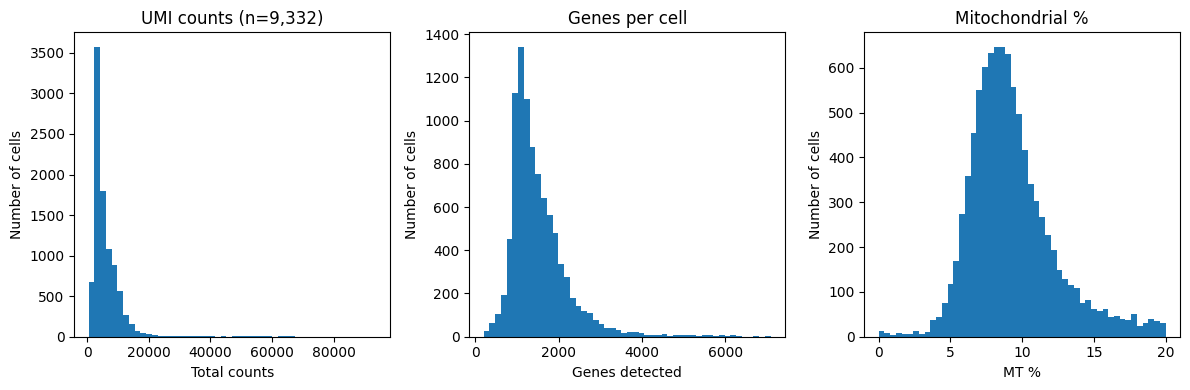


Filtered RNA statistics:
  Median UMI/cell: 4558
  Median genes/cell: 1340
  Median MT%: 8.8


In [7]:
# Visualize QC after filtering
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(rna_adata.obs['total_counts'], bins=50)
axes[0].set_xlabel('Total counts')
axes[0].set_ylabel('Number of cells')
axes[0].set_title(f'UMI counts (n={rna_adata.n_obs:,})')

axes[1].hist(rna_adata.obs['n_genes_by_counts'], bins=50)
axes[1].set_xlabel('Genes detected')
axes[1].set_ylabel('Number of cells')
axes[1].set_title('Genes per cell')

axes[2].hist(rna_adata.obs['pct_counts_mt'], bins=50)
axes[2].set_xlabel('MT %')
axes[2].set_ylabel('Number of cells')
axes[2].set_title('Mitochondrial %')

plt.tight_layout()
plt.show()

print(f"\nFiltered RNA statistics:")
print(f"  Median UMI/cell: {rna_adata.obs['total_counts'].median():.0f}")
print(f"  Median genes/cell: {rna_adata.obs['n_genes_by_counts'].median():.0f}")
print(f"  Median MT%: {rna_adata.obs['pct_counts_mt'].median():.1f}")

### Build protein-gene correspondence

In [8]:
# Load correspondence table
correspondence = pd.read_csv('protein_gene_conversion.csv', encoding='utf-8-sig')

# Find matching features
rna_protein_correspondence = []
for i in range(correspondence.shape[0]):
    prot, rnas = correspondence.iloc[i]
    if prot not in protein_adata.var_names:
        continue
    if 'Ignore' in str(rnas):
        continue
    for r in str(rnas).split('/'):
        if r in rna_adata.var_names:
            rna_protein_correspondence.append([r, prot])
            break  # Take first match only

rna_protein_correspondence = np.array(rna_protein_correspondence)
print(f"Found {len(rna_protein_correspondence)} protein-gene pairs")

# Remove duplicates (same RNA mapping to multiple proteins)
# Keep CD45 but remove CD45RO since they map to same gene (PTPRC)
seen_rna = set()
unique_pairs = []
for rna, prot in rna_protein_correspondence:
    if rna not in seen_rna:
        seen_rna.add(rna)
        unique_pairs.append([rna, prot])
rna_protein_correspondence = np.array(unique_pairs)
print(f"After removing duplicates: {len(rna_protein_correspondence)} pairs")

print("\nMatched features:")
for rna, prot in rna_protein_correspondence:
    print(f"  {rna:15} <-> {prot}")

Found 24 protein-gene pairs
After removing duplicates: 23 pairs

Matched features:
  CD4             <-> CD4
  CD8A            <-> CD8
  PTPRC           <-> CD45
  ITGAX           <-> CD11c
  CD34            <-> CD34
  CD44            <-> CD44
  MS4A1           <-> CD20
  PECAM1          <-> CD31
  LAMP1           <-> CD107a
  HLA-DRA         <-> HLADR
  CD1C            <-> CD1c
  CR1             <-> CD35
  CR2             <-> CD21
  CD68            <-> CD68
  CD163           <-> CD163
  FUT4            <-> CD15
  FOXP3           <-> FoxP3
  MKI67           <-> Ki67
  VIM             <-> Vimentin
  CD3E            <-> CD3e
  LYVE1           <-> Lyve1
  ACTA2           <-> SMActin
  COL4A1          <-> CollagenIV


### Extract shared feature arrays (AFTER filtering)

In [9]:
# Extract shared features from FILTERED data
rna_shared_adata = rna_adata[:, rna_protein_correspondence[:, 0]].copy()
protein_shared_adata = protein_adata[:, rna_protein_correspondence[:, 1]].copy()

print(f"rna_shared_adata: {rna_shared_adata.shape}")
print(f"protein_shared_adata: {protein_shared_adata.shape}")

rna_shared_adata: (9332, 23)
protein_shared_adata: (189470, 23)


### Normalize shared arrays

In [10]:
# Normalize RNA shared features
sc.pp.normalize_total(rna_shared_adata)
sc.pp.log1p(rna_shared_adata)
sc.pp.scale(rna_shared_adata)

# Check if protein needs normalization (CODEX data is often pre-normalized)
prot_mean = protein_shared_adata.X.mean()
prot_std = protein_shared_adata.X.std()
print(f"Protein shared - mean: {prot_mean:.4f}, std: {prot_std:.4f}")

# Scale protein if not already centered
if abs(prot_mean) > 0.1 or abs(prot_std - 1.0) > 0.5:
    print("Scaling protein shared features...")
    sc.pp.scale(protein_shared_adata)
    print(f"After scaling - mean: {protein_shared_adata.X.mean():.4f}, std: {protein_shared_adata.X.std():.4f}")

Protein shared - mean: 1.0144, std: 1.4572
Scaling protein shared features...
After scaling - mean: -0.0000, std: 1.0000


In [11]:
# Convert to numpy arrays
rna_shared = rna_shared_adata.X.copy()
if sparse.issparse(rna_shared):
    rna_shared = rna_shared.toarray()
    
protein_shared = protein_shared_adata.X.copy()
if sparse.issparse(protein_shared):
    protein_shared = protein_shared.toarray()

# Remove zero-variance features
rna_std = rna_shared.std(axis=0)
prot_std = protein_shared.std(axis=0)
valid_mask = (rna_std > 1e-6) & (prot_std > 1e-6)

if not valid_mask.all():
    print(f"Removing {(~valid_mask).sum()} zero-variance features")
    rna_shared = rna_shared[:, valid_mask]
    protein_shared = protein_shared[:, valid_mask]

print(f"\nFinal shared arrays:")
print(f"  rna_shared: {rna_shared.shape}")
print(f"  protein_shared: {protein_shared.shape}")


Final shared arrays:
  rna_shared: (9332, 23)
  protein_shared: (189470, 23)


### Diagnostic: Shared Feature Quality Analysis

This is critical for understanding integration quality. We check:
1. Expression distribution of each shared feature
2. **Dropout rate** (% of cells with zero expression) - high dropout weakens the linkage signal
3. Cross-modality correlation at population level

In [12]:
# Analyze shared feature quality
print("=" * 60)
print("SHARED FEATURE QUALITY ANALYSIS")
print("=" * 60)

# Get raw counts for analysis (before normalization)
rna_raw_shared = rna_adata[:, rna_protein_correspondence[:, 0]].X
if sparse.issparse(rna_raw_shared):
    rna_raw_shared = rna_raw_shared.toarray()

protein_raw_shared = protein_adata[:, rna_protein_correspondence[:, 1]].X
if sparse.issparse(protein_raw_shared):
    protein_raw_shared = protein_raw_shared.toarray()

# Calculate statistics for each feature
feature_stats = []
for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    rna_col = rna_raw_shared[:, i]
    prot_col = protein_raw_shared[:, i]
    
    # Dropout = % cells with zero expression (gene not detected)
    rna_dropout = (rna_col == 0).sum() / len(rna_col) * 100
    prot_dropout = (prot_col == 0).sum() / len(prot_col) * 100
    
    # Mean expression (in cells where detected)
    rna_mean_expr = rna_col[rna_col > 0].mean() if (rna_col > 0).any() else 0
    prot_mean_expr = prot_col[prot_col > 0].mean() if (prot_col > 0).any() else 0
    
    # % cells expressing (inverse of dropout)
    rna_pct_expressing = 100 - rna_dropout
    prot_pct_expressing = 100 - prot_dropout
    
    feature_stats.append({
        'RNA_gene': rna_gene,
        'Protein': prot_marker,
        'RNA_%_expressing': rna_pct_expressing,
        'Prot_%_expressing': prot_pct_expressing,
        'RNA_mean_when_expressed': rna_mean_expr,
        'Prot_mean_when_expressed': prot_mean_expr,
    })

stats_df = pd.DataFrame(feature_stats)
stats_df = stats_df.sort_values('RNA_%_expressing', ascending=True)

print("\nFeature-by-feature statistics (sorted by RNA detection rate):")
print(stats_df.to_string(index=False))

# Summary
print(f"\n{'='*60}")
print("SUMMARY:")
avg_rna_detection = stats_df['RNA_%_expressing'].mean()
avg_prot_detection = stats_df['Prot_%_expressing'].mean()
print(f"  Average RNA detection rate: {avg_rna_detection:.1f}% of cells")
print(f"  Average Protein detection rate: {avg_prot_detection:.1f}% of cells")

# Identify features rarely detected in RNA (<10% of cells)
rare_features = stats_df[stats_df['RNA_%_expressing'] < 10]
if len(rare_features) > 0:
    print(f"\n  WARNING: {len(rare_features)} features detected in <10% of RNA cells:")
    for _, row in rare_features.iterrows():
        print(f"    {row['RNA_gene']} (detected in {row['RNA_%_expressing']:.1f}% of cells)")
    print("  These features provide weak signal for matching cells!")

SHARED FEATURE QUALITY ANALYSIS

Feature-by-feature statistics (sorted by RNA detection rate):
RNA_gene    Protein  RNA_%_expressing  Prot_%_expressing  RNA_mean_when_expressed Prot_mean_when_expressed
   FOXP3      FoxP3          0.085727           1.056104                 1.375000                1.9861876
  COL4A1 CollagenIV          0.214316          78.822505                 3.000000                2.7993767
    CD34       CD34          0.267895          21.927482                 1.480000                2.4132519
   LYVE1      Lyve1          0.717960          41.912176                 2.417910                 2.620766
   ACTA2    SMActin          1.543078          71.692088                 1.437500                2.8314908
    FUT4       CD15          1.564509          35.614609                 1.061644                 2.814697
   MKI67       Ki67          2.025289           1.521613                 4.772487                3.4302807
    CD1C       CD1c          2.882555          11

In [13]:
# Investigate CD34 expression specifically
print("=" * 60)
print("CD34 EXPRESSION ANALYSIS")
print("=" * 60)

# Check if CD34 is in the data
if 'CD34' in rna_adata.var_names:
    cd34_expr = rna_adata[:, 'CD34'].X
    if sparse.issparse(cd34_expr):
        cd34_expr = cd34_expr.toarray().flatten()
    else:
        cd34_expr = cd34_expr.flatten()
    
    n_expressing = (cd34_expr > 0).sum()
    pct_expressing = n_expressing / len(cd34_expr) * 100
    
    print(f"CD34 in RNA data:")
    print(f"  Total cells: {len(cd34_expr):,}")
    print(f"  Cells with CD34 > 0: {n_expressing:,} ({pct_expressing:.2f}%)")
    print(f"  Max expression value: {cd34_expr.max():.1f}")
    print(f"  Mean (when expressed): {cd34_expr[cd34_expr > 0].mean():.2f}" if n_expressing > 0 else "  N/A")
    
    # Distribution of non-zero values
    if n_expressing > 0:
        print(f"\n  Expression distribution (non-zero cells):")
        nonzero = cd34_expr[cd34_expr > 0]
        print(f"    Min: {nonzero.min():.1f}")
        print(f"    Median: {np.median(nonzero):.1f}")
        print(f"    Max: {nonzero.max():.1f}")
else:
    print("CD34 not found in RNA data!")

# Compare to protein
print(f"\nCD34 in Protein data:")
if 'CD34' in protein_adata.var_names:
    cd34_prot = protein_adata[:, 'CD34'].X
    if sparse.issparse(cd34_prot):
        cd34_prot = cd34_prot.toarray().flatten()
    else:
        cd34_prot = cd34_prot.flatten()
    
    n_expressing_prot = (cd34_prot > 0).sum()
    pct_expressing_prot = n_expressing_prot / len(cd34_prot) * 100
    
    print(f"  Total cells: {len(cd34_prot):,}")
    print(f"  Cells with CD34 > 0: {n_expressing_prot:,} ({pct_expressing_prot:.2f}%)")

# Check other endothelial/vascular markers for context
print(f"\n" + "=" * 60)
print("OTHER VASCULAR MARKERS IN RNA:")
print("=" * 60)
vascular_genes = ['CD34', 'PECAM1', 'VWF', 'CDH5', 'KDR', 'FLT1', 'LYVE1', 'ENG', 'TEK']
for gene in vascular_genes:
    if gene in rna_adata.var_names:
        expr = rna_adata[:, gene].X
        if sparse.issparse(expr):
            expr = expr.toarray().flatten()
        n_expr = (expr > 0).sum()
        pct = n_expr / len(expr) * 100
        print(f"  {gene:10}: {n_expr:5,} cells ({pct:5.2f}%)")
    else:
        print(f"  {gene:10}: NOT FOUND")

CD34 EXPRESSION ANALYSIS
CD34 in RNA data:
  Total cells: 9,332
  Cells with CD34 > 0: 25 (0.27%)
  Max expression value: 4.0
  Mean (when expressed): 1.48

  Expression distribution (non-zero cells):
    Min: 1.0
    Median: 1.0
    Max: 4.0

CD34 in Protein data:
  Total cells: 189,470
  Cells with CD34 > 0: 41,546 (21.93%)

OTHER VASCULAR MARKERS IN RNA:
  CD34      :    25 cells ( 0.27%)
  PECAM1    : 1,285 cells (13.77%)
  VWF       :    26 cells ( 0.28%)
  CDH5      :    20 cells ( 0.21%)
  KDR       :     3 cells ( 0.03%)
  FLT1      :   878 cells ( 9.41%)
  LYVE1     :    67 cells ( 0.72%)
  ENG       :   371 cells ( 3.98%)
  TEK       :    17 cells ( 0.18%)


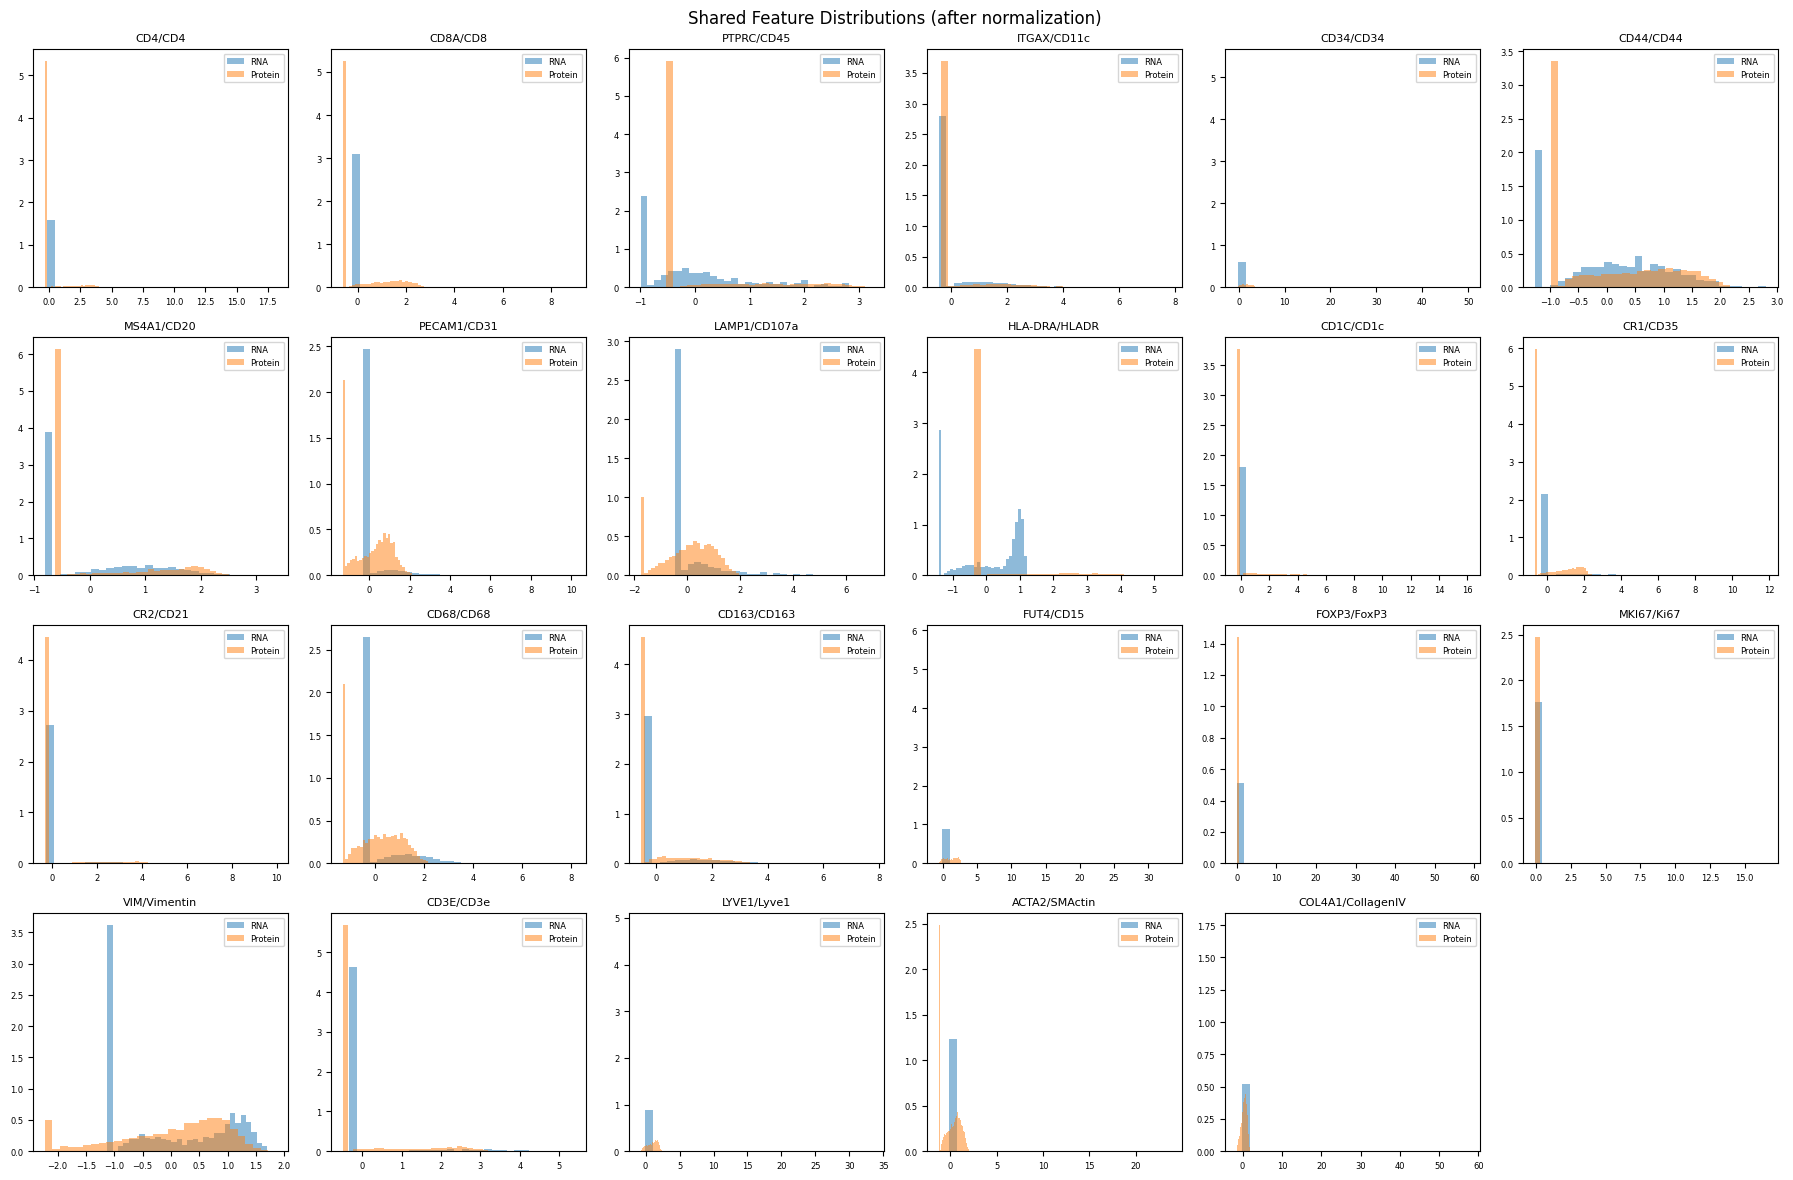

In [14]:
# Visualize shared feature distributions
fig, axes = plt.subplots(4, 6, figsize=(18, 12))
axes = axes.flatten()

for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    if i >= len(axes):
        break
    ax = axes[i]
    
    # Get normalized values
    rna_vals = rna_shared[:, i]
    prot_vals = protein_shared[:, i]
    
    # Subsample protein for visualization
    prot_subsample = np.random.choice(len(prot_vals), min(5000, len(prot_vals)), replace=False)
    
    ax.hist(rna_vals, bins=30, alpha=0.5, label='RNA', density=True)
    ax.hist(prot_vals[prot_subsample], bins=30, alpha=0.5, label='Protein', density=True)
    ax.set_title(f'{rna_gene}/{prot_marker}', fontsize=8)
    ax.legend(fontsize=6)
    ax.tick_params(labelsize=6)

# Hide unused subplots
for i in range(len(rna_protein_correspondence), len(axes)):
    axes[i].axis('off')

plt.suptitle('Shared Feature Distributions (after normalization)', fontsize=12)
plt.tight_layout()
plt.show()

In [15]:
# Population-level correlation analysis
# Compare variance structure between modalities

print("=" * 60)
print("POPULATION-LEVEL CORRELATION ANALYSIS")
print("=" * 60)

# Compare variance structure between modalities
rna_feature_vars = rna_shared.var(axis=0)
prot_feature_vars = protein_shared.var(axis=0)

# Correlation of variance structure between modalities
from scipy.stats import spearmanr, pearsonr

var_corr, var_pval = spearmanr(rna_feature_vars, prot_feature_vars)
print(f"\nVariance structure correlation (Spearman): r={var_corr:.3f}, p={var_pval:.2e}")
print("  (High correlation suggests similar features are informative in both modalities)")

# More informative: correlation of expression distributions
print("\n" + "=" * 60)
print("Per-feature variance comparison:")
print("=" * 60)
for i, (rna_gene, prot_marker) in enumerate(rna_protein_correspondence):
    print(f"  {rna_gene:12} / {prot_marker:12}: RNA var={rna_feature_vars[i]:.3f}, Prot var={prot_feature_vars[i]:.3f}")

POPULATION-LEVEL CORRELATION ANALYSIS

Variance structure correlation (Spearman): r=-0.291, p=1.79e-01
  (High correlation suggests similar features are informative in both modalities)

Per-feature variance comparison:
  CD4          / CD4         : RNA var=1.000, Prot var=1.001
  CD8A         / CD8         : RNA var=1.000, Prot var=1.000
  PTPRC        / CD45        : RNA var=1.000, Prot var=1.001
  ITGAX        / CD11c       : RNA var=1.000, Prot var=1.000
  CD34         / CD34        : RNA var=1.000, Prot var=1.000
  CD44         / CD44        : RNA var=1.000, Prot var=1.001
  MS4A1        / CD20        : RNA var=1.000, Prot var=0.999
  PECAM1       / CD31        : RNA var=1.000, Prot var=1.000
  LAMP1        / CD107a      : RNA var=1.000, Prot var=1.000
  HLA-DRA      / HLADR       : RNA var=1.000, Prot var=0.997
  CD1C         / CD1c        : RNA var=1.000, Prot var=1.000
  CR1          / CD35        : RNA var=1.000, Prot var=1.001
  CR2          / CD21        : RNA var=1.000, Pro

### Prepare active arrays (all features)

In [16]:
# Process RNA active - use HVGs for integration, but keep full data for downstream analysis
rna_adata_active = rna_adata.copy()
sc.pp.normalize_total(rna_adata_active)
sc.pp.log1p(rna_adata_active)

# Select highly variable genes for integration (like the tutorial)
sc.pp.highly_variable_genes(rna_adata_active, n_top_genes=5000)
rna_adata_hvg = rna_adata_active[:, rna_adata_active.var['highly_variable']].copy()
sc.pp.scale(rna_adata_hvg, max_value=10)

# Also keep full scaled data for downstream gene queries
sc.pp.scale(rna_adata_active, max_value=10)

print(f"RNA active (HVGs for integration): {rna_adata_hvg.shape}")
print(f"RNA active (all genes for queries): {rna_adata_active.shape}")

# Verify key genes of interest are present in full data
genes_of_interest = ['SH2B3', 'CD34', 'PECAM1', 'VWF', 'CDH5', 'KDR', 'FLT1', 'LYVE1']
found_genes = [g for g in genes_of_interest if g in rna_adata_active.var_names]
missing_genes = [g for g in genes_of_interest if g not in rna_adata_active.var_names]
print(f"\nGenes of interest found: {found_genes}")
if missing_genes:
    print(f"Genes not found: {missing_genes}")

RNA active (HVGs for integration): (9332, 5000)
RNA active (all genes for queries): (9332, 18767)

Genes of interest found: ['SH2B3', 'CD34', 'PECAM1', 'VWF', 'CDH5', 'KDR', 'FLT1', 'LYVE1']


In [17]:
# Protein active - use all markers
protein_adata_active = protein_adata.copy()

# Scale if needed
prot_mean = protein_adata_active.X.mean()
if abs(prot_mean) > 0.1:
    sc.pp.scale(protein_adata_active)
    
print(f"Protein active: {protein_adata_active.shape}")

Protein active: (189470, 24)


In [18]:
# Extract numpy arrays - use HVGs for integration
rna_active = rna_adata_hvg.X.copy()
if sparse.issparse(rna_active):
    rna_active = rna_active.toarray()

protein_active = protein_adata_active.X.copy()
if sparse.issparse(protein_active):
    protein_active = protein_active.toarray()

# Remove zero-variance features
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-6]
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-6]

print(f"\nFinal active arrays:")
print(f"  rna_active (HVGs): {rna_active.shape}")
print(f"  protein_active: {protein_active.shape}")


Final active arrays:
  rna_active (HVGs): (9332, 5000)
  protein_active: (189470, 24)


### CRITICAL VALIDATION: Check array dimensions match

In [19]:
# Validate dimensions
print("=" * 50)
print("DIMENSION VALIDATION")
print("=" * 50)
print(f"RNA shared cells:     {rna_shared.shape[0]}")
print(f"RNA active cells:     {rna_active.shape[0]}")
print(f"Protein shared cells: {protein_shared.shape[0]}")
print(f"Protein active cells: {protein_active.shape[0]}")
print()

assert rna_shared.shape[0] == rna_active.shape[0], \
    f"RNA mismatch: shared={rna_shared.shape[0]}, active={rna_active.shape[0]}"
assert protein_shared.shape[0] == protein_active.shape[0], \
    f"Protein mismatch: shared={protein_shared.shape[0]}, active={protein_active.shape[0]}"
assert rna_shared.shape[1] == protein_shared.shape[1], \
    f"Shared feature mismatch: RNA={rna_shared.shape[1]}, Protein={protein_shared.shape[1]}"

print("All dimensions validated!")
print(f"\nIntegrating {rna_active.shape[0]} RNA cells with {protein_active.shape[0]} protein cells")
print(f"Using {rna_shared.shape[1]} shared features for initialization")

DIMENSION VALIDATION
RNA shared cells:     9332
RNA active cells:     9332
Protein shared cells: 189470
Protein active cells: 189470

All dimensions validated!

Integrating 9332 RNA cells with 189470 protein cells
Using 23 shared features for initialization


## Step 2: Initialize MaxFuse

**Important**: Since clusters in RNA and CODEX don't correspond to the same cell types,
we let MaxFuse perform its own clustering (`labels1=None, labels2=None`).

In [20]:
# Create Fusor - let MaxFuse cluster automatically
fusor = mf.model.Fusor(
    shared_arr1=rna_shared,
    shared_arr2=protein_shared,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,  # Don't use RNA clusters - they don't match protein
    labels2=None,  # Don't use protein clusters
    method='centroid_shrinkage'
)

In [21]:
# Calculate appropriate batching parameters
n_rna = rna_active.shape[0]
n_prot = protein_active.shape[0]
ratio = n_prot / n_rna

print(f"RNA cells: {n_rna}")
print(f"Protein cells: {n_prot}")
print(f"Ratio (protein/RNA): {ratio:.1f}")

# Batching parameters - reasoning for each:
# 
# matching_ratio: Controls batch size ratio between protein and RNA.
# Tutorial uses 4 with a ~14:1 data ratio. Your data is ~17:1.
# Using a higher ratio (e.g., 10-15) keeps everything in fewer batches,
# which is fine for datasets this size. The linear assignment will still
# find optimal 1:1 matches within each batch.
#
# metacell_size: Aggregates RNA cells into metacells to reduce noise.
# Tutorial uses 2. This helps with weak linkage scenarios.

max_outward = min(8000, n_rna)
matching_ratio = 15  # Adjusted for 17:1 ratio - keeps batches manageable
metacell_sz = 2  # Metacell aggregation helps with noise

print(f"\nBatching parameters:")
print(f"  max_outward_size: {max_outward}")
print(f"  matching_ratio: {matching_ratio}")
print(f"  metacell_size: {metacell_sz}")
print(f"  Expected protein batch size: ~{max_outward * matching_ratio}")

RNA cells: 9332
Protein cells: 189470
Ratio (protein/RNA): 20.3

Batching parameters:
  max_outward_size: 8000
  matching_ratio: 15
  metacell_size: 2
  Expected protein batch size: ~120000


In [22]:
fusor.split_into_batches(
    max_outward_size=max_outward,
    matching_ratio=matching_ratio,  # Fixed: was match_ratio
    metacell_size=metacell_sz,
    verbose=True
)

The first data is split into 1 batches, average batch size is 9332, and max batch size is 9332.
The second data is split into 1 batches, average batch size is 189470, and max batch size is 189470.
Batch to batch correspondence is:
  ['0<->0'].


### Determine SVD components from singular value plots

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

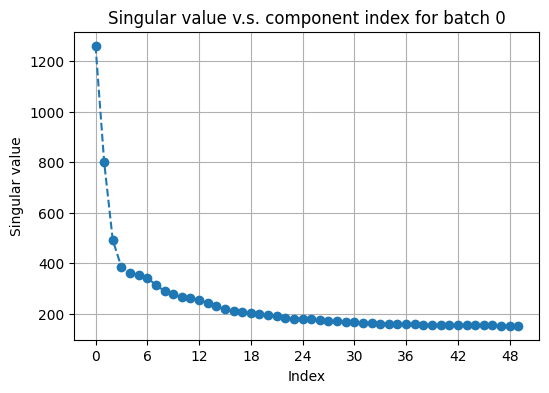

In [23]:
fusor.plot_singular_values(target='active_arr1', n_components=50)

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

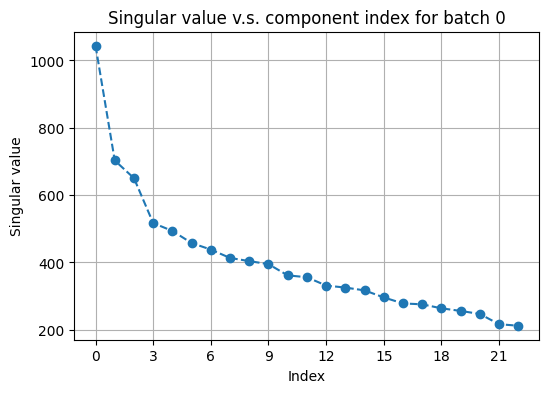

In [24]:
fusor.plot_singular_values(target='active_arr2', n_components=min(23, protein_active.shape[1]-1))

In [25]:
# Set SVD components based on data dimensions - matching tutorial
n_prot_features = protein_active.shape[1]
n_rna_features = rna_active.shape[1]
n_shared = rna_shared.shape[1]

# For graph construction - tutorial uses 40 for RNA, 15 for protein
svd_comp1_graph = min(40, n_rna_features - 1)  # Tutorial: 40
svd_comp2_graph = min(15, n_prot_features - 1)  # Tutorial: 15

print(f"Data dimensions:")
print(f"  RNA features: {n_rna_features}")
print(f"  Protein features: {n_prot_features}")
print(f"\nGraph construction SVD components (matching tutorial):")
print(f"  RNA: {svd_comp1_graph}")
print(f"  Protein: {svd_comp2_graph}")

Data dimensions:
  RNA features: 5000
  Protein features: 24

Graph construction SVD components (matching tutorial):
  RNA: 40
  Protein: 15


In [26]:
# Construct graphs with automatic clustering
# KEY CHANGE: Higher resolution (2.0) like tutorial for better cluster granularity
fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=svd_comp1_graph,
    svd_components2=svd_comp2_graph,
    resolution1=2.0,   # Tutorial uses 2.0 (not 0.5!)
    resolution2=2.0,   # Higher resolution = more clusters = finer smoothing
    resolution_tol=0.1,
    leiden_runs=1,
    verbose=True
)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


## Step 3: Find Initial Pivots

Using shared features (protein-gene pairs) for initial matching.
For weak-linkage spatial data, use stronger smoothing (lower weights).

Text(0.5, 1.0, 'Protein Shared - Singular Values')

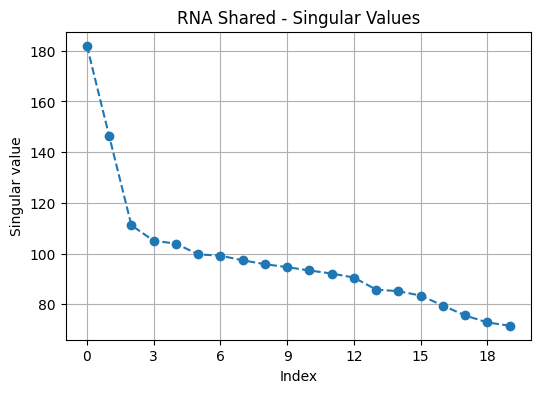

<Figure size 600x400 with 0 Axes>

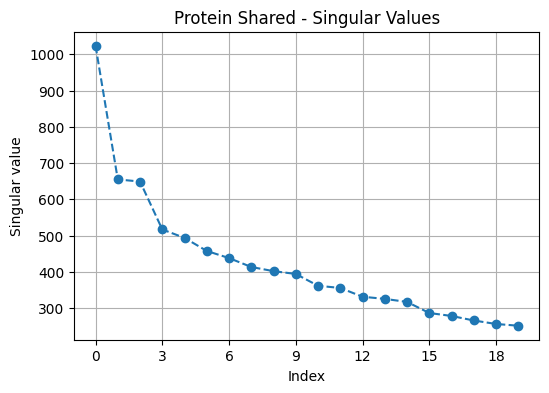

In [27]:
# Check shared feature singular values
fusor.plot_singular_values(target='shared_arr1', n_components=min(20, n_shared-1))
plt.title('RNA Shared - Singular Values')

plt.figure()
fusor.plot_singular_values(target='shared_arr2', n_components=min(20, n_shared-1))
plt.title('Protein Shared - Singular Values')

In [28]:
# SVD components for shared features - matching tutorial
# Tutorial uses 25 for RNA shared, 20 for protein shared
svd_shared1 = min(25, n_shared - 1)  # Tutorial: 25
svd_shared2 = min(20, n_shared - 1)  # Tutorial: 20
print(f"Using {svd_shared1}/{svd_shared2} SVD components for shared features")

# Find initial pivots with smoothing for weak linkage
fusor.find_initial_pivots(
    wt1=0.3,  # Tutorial uses 0.3
    wt2=0.3,
    svd_components1=svd_shared1,
    svd_components2=svd_shared2,
    verbose=True
)

Using 22/20 SVD components for shared features
Now at batch 0<->0...
Done!


## Step 4: Refine Pivots

Use CCA on active features to refine the initial matching.

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

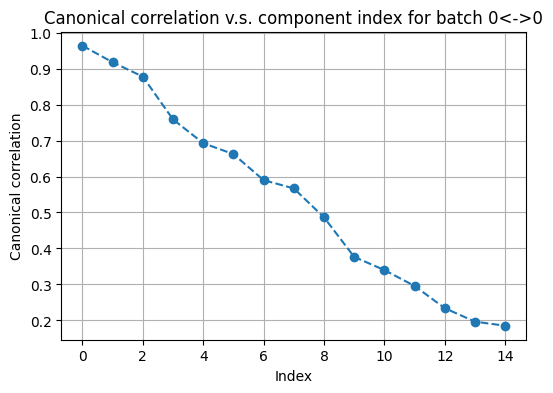

In [29]:
# Check canonical correlations
cca_comp_check = min(15, n_prot_features - 1)
fusor.plot_canonical_correlations(
    svd_components1=min(30, n_rna_features - 1),
    svd_components2=None,  # Don't reduce protein (already low-dim)
    cca_components=cca_comp_check
)

In [30]:
# Set refinement parameters - matching tutorial
# Tutorial uses 25 CCA components
cca_components = min(25, n_prot_features - 1)  # Tutorial: 25

print(f"Refinement parameters (matching tutorial):")
print(f"  CCA components: {cca_components}")
print(f"  SVD for RNA: {min(40, n_rna_features - 1)}")
print(f"  SVD for Protein: None (use all {n_prot_features} features)")

Refinement parameters (matching tutorial):
  CCA components: 23
  SVD for RNA: 40
  SVD for Protein: None (use all 24 features)


In [31]:
# Refine pivots - matching tutorial parameters
fusor.refine_pivots(
    wt1=0.3,  # Tutorial uses 0.3
    wt2=0.3,
    svd_components1=min(40, n_rna_features - 1),  # Tutorial: 40
    svd_components2=None,  # Keep all protein features
    cca_components=cca_components,
    n_iters=1,  # Tutorial uses 1 iteration
    filter_prop=0.0,  # Don't filter during refinement
    verbose=True
)

Now at batch 0<->0...
Done!


In [32]:
# Filter bad pivots - be aggressive for weak linkage
fusor.filter_bad_matches(
    target='pivot',
    filter_prop=0.5,  # Remove bottom 50%
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
2333/4665 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
4751/9332 cells in arr1 are selected as pivots.
2333/189470 cells in arr2 are selected as pivots.
Done!


In [33]:
# Check pivot matching (just for diagnostics, not accuracy since labels don't correspond)
pivot_matching = fusor.get_matching(order=(2, 1), target='pivot')
print(f"Pivot matches: {len(pivot_matching[0])}")
print(f"Unique RNA cells matched: {len(np.unique(pivot_matching[0]))}")
print(f"Unique Protein cells matched: {len(np.unique(pivot_matching[1]))}")
print(f"Score range: [{min(pivot_matching[2]):.3f}, {max(pivot_matching[2]):.3f}]")
print(f"Mean score: {np.mean(pivot_matching[2]):.3f}")

Pivot matches: 4751
Unique RNA cells matched: 4751
Unique Protein cells matched: 2333
Score range: [0.145, 0.983]
Mean score: 0.720


## Step 5: Propagate to All Cells

In [34]:
fusor.propagate(
    svd_components1=min(40, n_rna_features - 1),  # Tutorial: 40
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
    verbose=True
)

Now at batch 0<->0...
Done!


In [35]:
# Filter propagated matches
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3,  # Remove bottom 30%
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
132628/189469 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [36]:
# Get full matching
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

print(f"\nFull matching results:")
print(f"  Total matches: {len(full_matching[0])}")
print(f"  Unique RNA cells: {len(np.unique(full_matching[0]))}")
print(f"  Unique Protein cells: {len(np.unique(full_matching[1]))}")
print(f"  Score range: [{min(full_matching[2]):.3f}, {max(full_matching[2]):.3f}]")


Full matching results:
  Total matches: 134894
  Unique RNA cells: 3776
  Unique Protein cells: 134894
  Score range: [-0.189, 0.983]


In [37]:
# View matching table
matching_df = pd.DataFrame({
    'rna_idx': full_matching[0],
    'protein_idx': full_matching[1],
    'score': full_matching[2]
})
matching_df.head(20)

rna_idx  protein_idx     score
0      3864            9  0.759382
1      8479           60  0.797669
2      2292          120  0.891088
3      5451          130  0.900018
4      3854          141  0.724101
5      1260          247  0.756737
6      8481          365  0.731570
7      8624          381  0.867509
8      6888          489  0.802903
9      1529          720  0.697680
10     9204          722  0.699766
11     2377          733  0.832938
12     4714          742  0.690006
13      338          771  0.863437
14     7244          776  0.757037
15     5660          777  0.762676
16     7792          813  0.685884
17     7440          910  0.715480
18     9139         1034  0.874629
19     4740         1112  0.723152

## Step 6: Joint Embedding and Visualization

In [38]:
# Get CCA embedding for matched cells
# Use the HVG active arrays that were used for integration
rna_cca, protein_cca_matched = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2[full_matching[1], :]
)

print(f"RNA CCA embedding: {rna_cca.shape}")
print(f"Protein CCA embedding (matched): {protein_cca_matched.shape}")

RNA CCA embedding: (9332, 23)
Protein CCA embedding (matched): (134894, 23)


In [39]:
# Subsample for visualization
np.random.seed(42)
n_subsample = min(3000, protein_cca_matched.shape[0])
subsample_idx = np.random.choice(protein_cca_matched.shape[0], n_subsample, replace=False)

# Number of CCA dimensions to use for UMAP - use all available
dim_use = rna_cca.shape[1]

# Create combined embedding
combined_cca = np.vstack([
    rna_cca[:, :dim_use],
    protein_cca_matched[subsample_idx, :dim_use]
])

cca_adata = ad.AnnData(combined_cca, dtype=np.float32)
cca_adata.obs['modality'] = (['RNA'] * rna_cca.shape[0] + 
                              ['Protein'] * n_subsample)

print(f"Combined embedding: {cca_adata.shape}")

Combined embedding: (12332, 23)


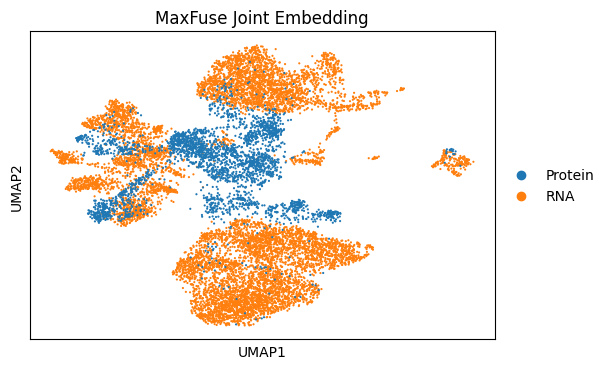

In [40]:
# Compute UMAP
sc.pp.neighbors(cca_adata, n_neighbors=15)
sc.tl.umap(cca_adata)

# Plot by modality
sc.pl.umap(cca_adata, color='modality', title='MaxFuse Joint Embedding')

### Visualize by marker expression

In [41]:
# Map markers to visualize
marker_map = {
    'CD31': 'PECAM1',
    'CD8': 'CD8A',
    'CD20': 'MS4A1',
    'CD3e': 'CD3E',
    'CD34': 'CD34',
    'CD68': 'CD68',
}

n_rna = rna_cca.shape[0]

# Convert matching results to numpy arrays for proper indexing
matched_protein_arr = np.array(full_matching[1])

for prot_marker, rna_gene in marker_map.items():
    marker_vals = np.zeros(cca_adata.n_obs)
    
    # RNA values
    if rna_gene in rna_adata_active.var_names:
        rna_idx = list(rna_adata_active.var_names).index(rna_gene)
        rna_vals = rna_adata_active.X[:, rna_idx]
        if sparse.issparse(rna_vals):
            rna_vals = rna_vals.toarray().flatten()
        marker_vals[:n_rna] = rna_vals
    
    # Protein values - use the subsampled indices into the matched protein cells
    if prot_marker in protein_adata_active.var_names:
        prot_idx = list(protein_adata_active.var_names).index(prot_marker)
        # Get protein indices for subsampled matched cells
        prot_cell_indices = matched_protein_arr[subsample_idx]
        prot_vals = protein_adata_active.X[prot_cell_indices, prot_idx]
        marker_vals[n_rna:] = prot_vals
    
    # Z-score normalize each modality separately
    rna_part = marker_vals[:n_rna]
    prot_part = marker_vals[n_rna:]
    
    if rna_part.std() > 0:
        marker_vals[:n_rna] = (rna_part - rna_part.mean()) / rna_part.std()
    if prot_part.std() > 0:
        marker_vals[n_rna:] = (prot_part - prot_part.mean()) / prot_part.std()
    
    cca_adata.obs[prot_marker] = marker_vals

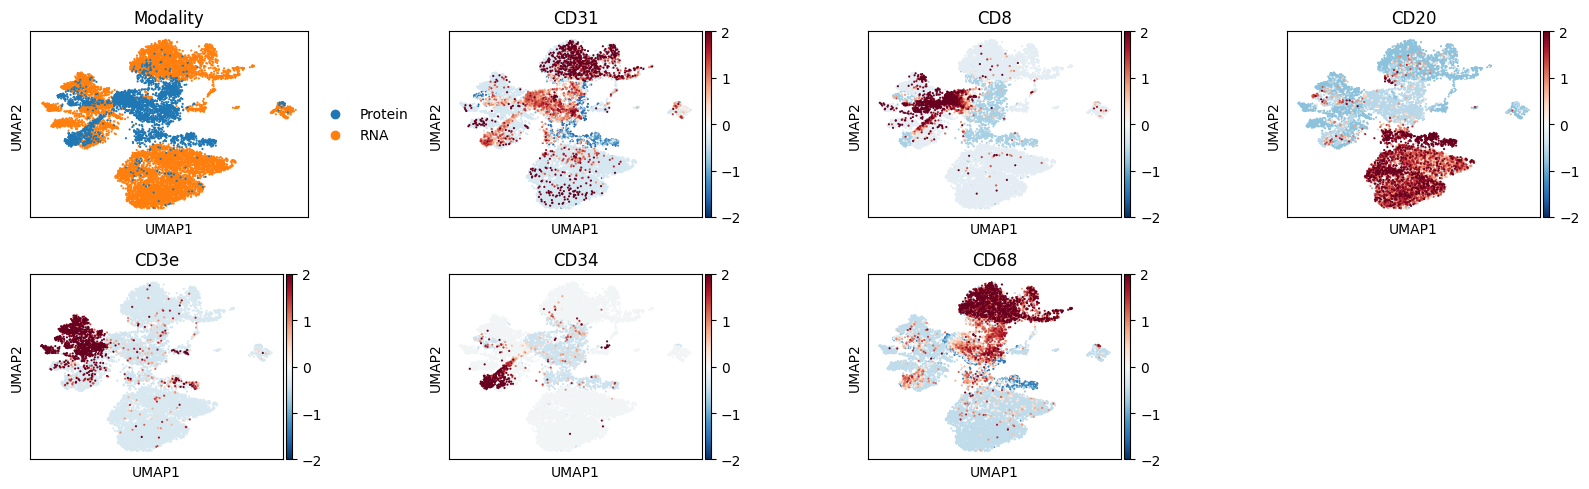

In [42]:
# Plot markers
fig, axes = plt.subplots(2, 4, figsize=(16,5))
axes = axes.flatten()

sc.pl.umap(cca_adata, color='modality', ax=axes[0], show=False, title='Modality')

for idx, marker in enumerate(list(marker_map.keys())):
    if idx + 1 < len(axes):
        sc.pl.umap(cca_adata, color=marker, ax=axes[idx+1], show=False,
                   title=marker, cmap='RdBu_r', vmin=-2, vmax=2)

axes[-1].axis('off')
plt.tight_layout()
plt.show()

## Step 7: Transfer RNA Information to Spatial Coordinates

Use the matching to project RNA expression onto CODEX spatial locations.

In [43]:
# Get spatial coordinates for matched protein cells
matched_protein_indices = full_matching[1]
matched_rna_indices = full_matching[0]

# Create dataframe with spatial coords and matched RNA info
spatial_df = pd.DataFrame({
    'x': protein_adata.obs['X_centroid'].values[matched_protein_indices],
    'y': protein_adata.obs['Y_centroid'].values[matched_protein_indices],
    'rna_idx': matched_rna_indices,
    'protein_idx': matched_protein_indices,
    'match_score': full_matching[2]
})

print(f"Spatial mapping: {len(spatial_df)} cells")
spatial_df.head()

Spatial mapping: 134894 cells


x           y  rna_idx  protein_idx  match_score
0  398.578125    2.875000     3864            9     0.759382
1  353.444444   40.185185     8479           60     0.797669
2  466.813084   89.747664     2292          120     0.891088
3  450.666667   92.866667     5451          130     0.900018
4  395.783333  102.316667     3854          141     0.724101

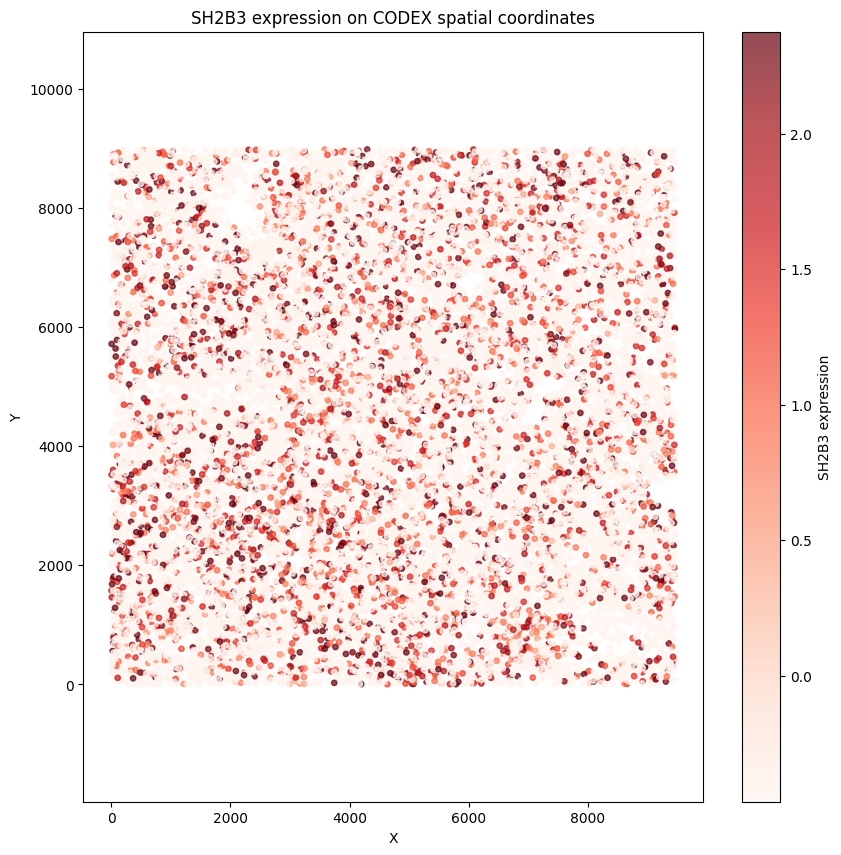

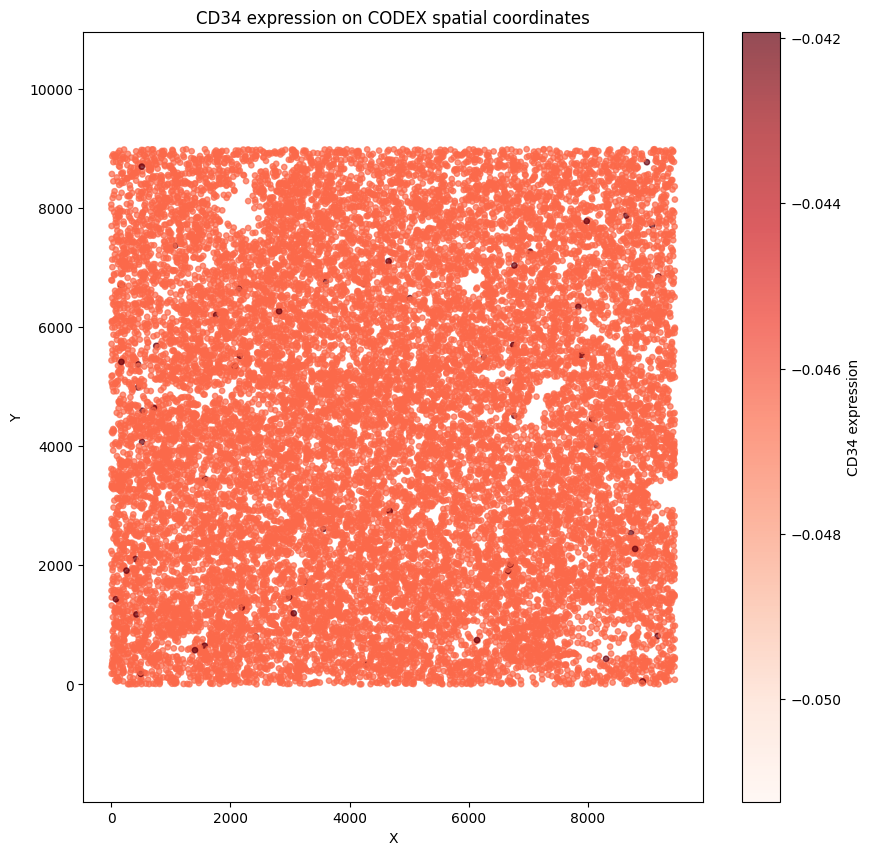

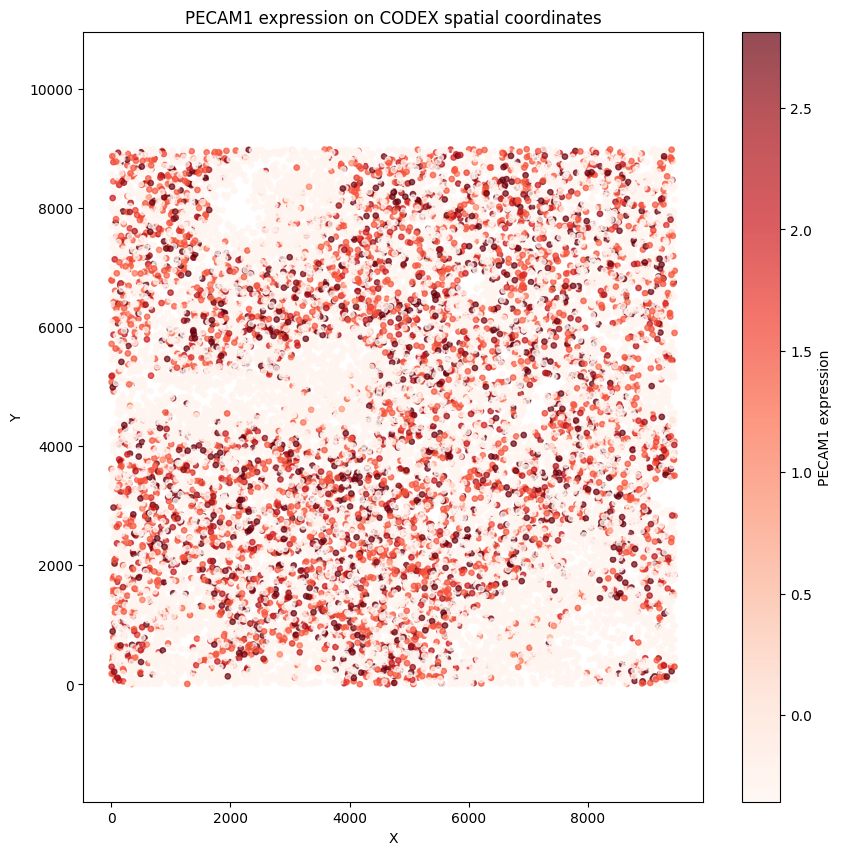

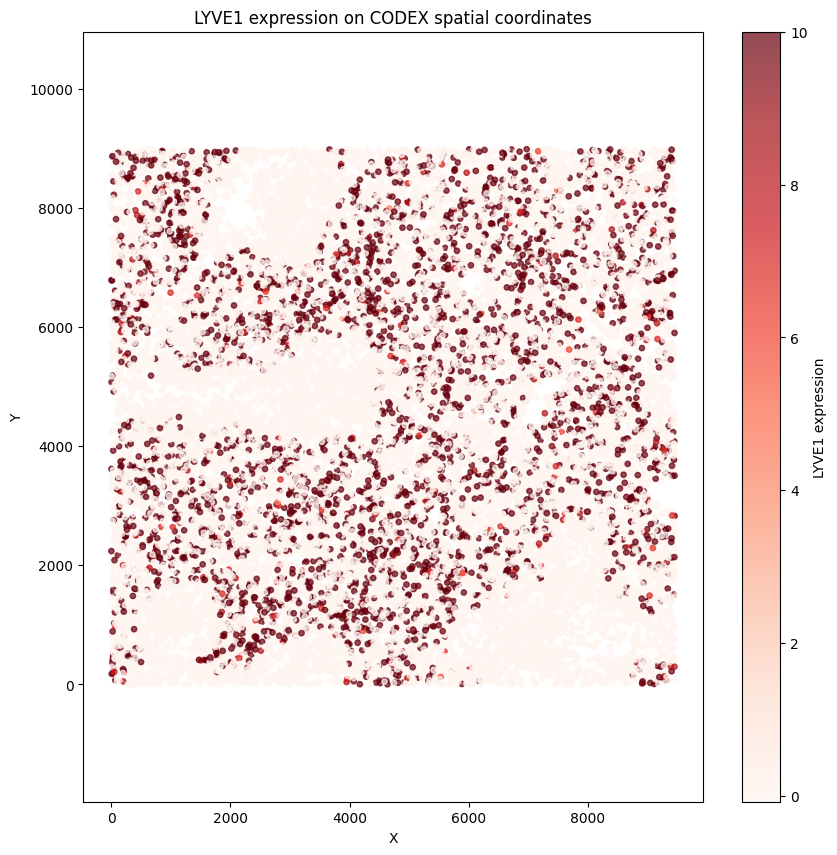

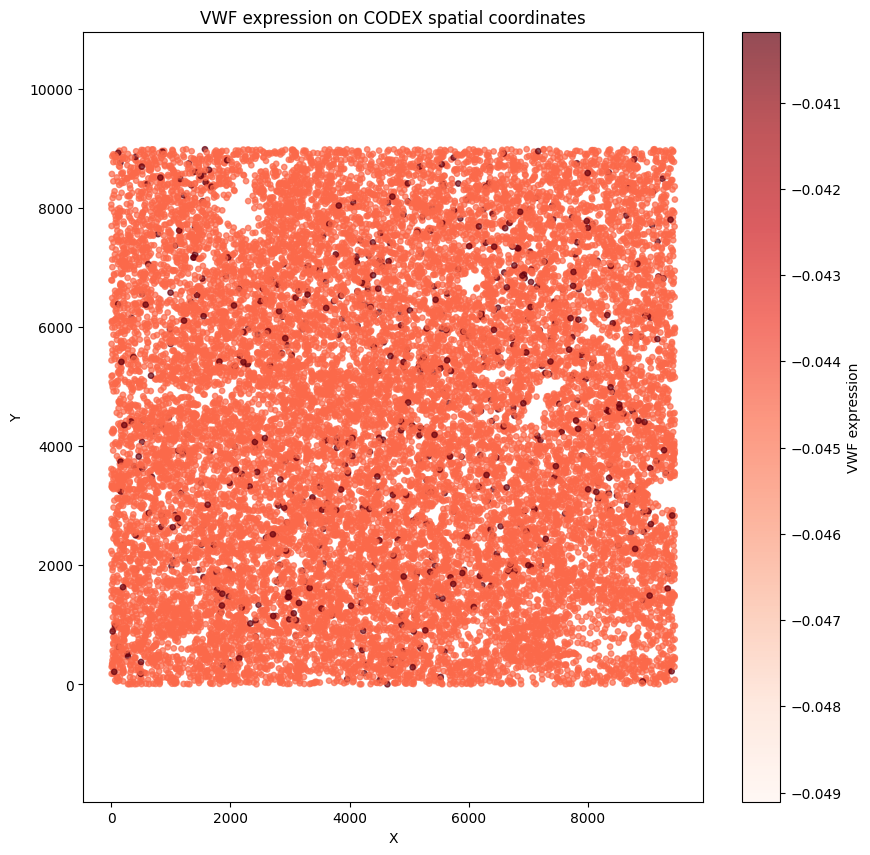

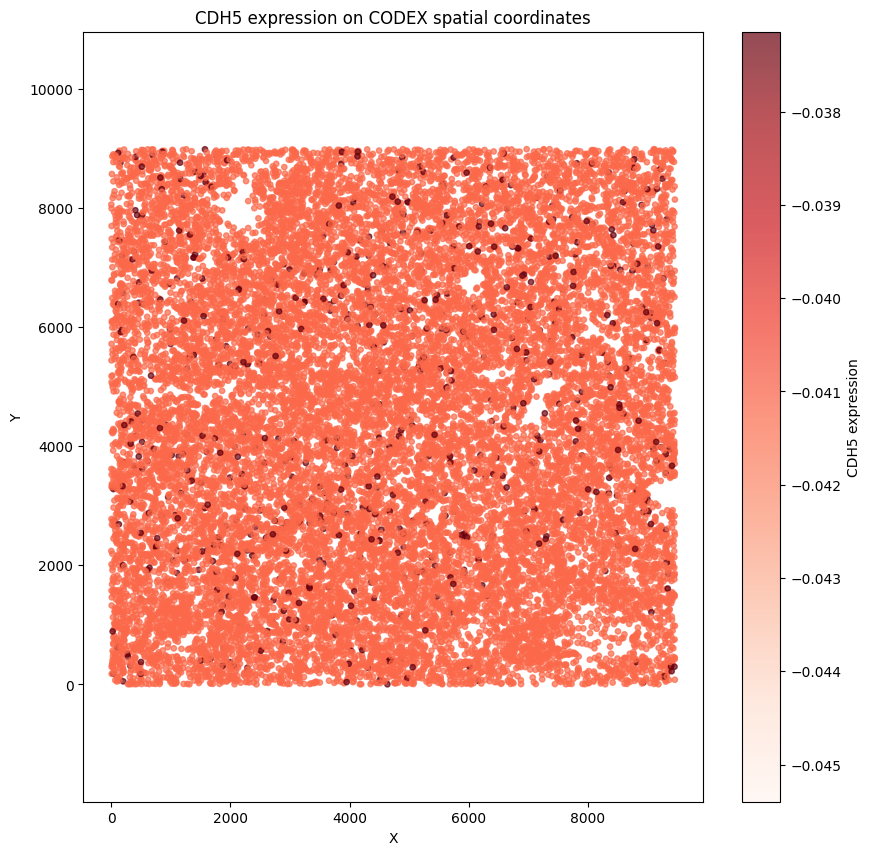

In [44]:
# Example: Plot gene expression on spatial coordinates
# Focus on SH2B3 and vascular markers relevant to risk genotype study

genes_to_plot = ['SH2B3', 'CD34', 'PECAM1', 'LYVE1', 'VWF', 'CDH5']

for gene_to_plot in genes_to_plot:
    if gene_to_plot in rna_adata_active.var_names:
        gene_idx = list(rna_adata_active.var_names).index(gene_to_plot)
        gene_expr = rna_adata_active.X[:, gene_idx]
        if sparse.issparse(gene_expr):
            gene_expr = gene_expr.toarray().flatten()
        
        # Map to spatial coordinates using matched RNA indices
        spatial_df['gene_expr'] = gene_expr[spatial_df['rna_idx'].values]
        
        # Subsample for plotting if too many cells
        plot_df = spatial_df.sample(n=min(20000, len(spatial_df)), random_state=42)
        
        plt.figure(figsize=(10, 10))
        plt.scatter(
            plot_df['x'], plot_df['y'],
            c=plot_df['gene_expr'],
            cmap='Reds', s=15, alpha=0.7, vmax=np.percentile(plot_df['gene_expr'], 96)
        )
        plt.colorbar(label=f'{gene_to_plot} expression')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'{gene_to_plot} expression on CODEX spatial coordinates')
        plt.axis('equal')
        plt.show()
    else:
        print(f"Gene {gene_to_plot} not found in RNA data.")

## Summary

Key differences from the original notebook:

1. **Data filtering order**: Filter both datasets BEFORE extracting shared features
2. **Dimension validation**: Explicit checks that shared and active arrays match
3. **No label correspondence assumed**: Using `labels1=None, labels2=None` since RNA and CODEX clusters don't correspond
4. **Conservative parameters**: Appropriate SVD/CCA components given the small number of protein features (24)
5. **Stronger smoothing**: Lower weights (0.2-0.3) for weak-linkage spatial data